In [23]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc, RocCurveDisplay
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Circle
from sklearn.model_selection import StratifiedKFold, train_test_split

In [18]:
os.chdir('./T-Matsuura_LDLT')
path = os.getcwd()


In [ ]:
clustlabel = pd.read_csv(path+'/Data/ClustLabel_revise.csv',index_col = 0)
train_X_180 = pd.read_csv(path+'/Data/train_X_180_revise.csv',index_col = 0)
train_y_180 = pd.read_csv(path+'/Data/train_y_180_revise.csv',index_col = 0)

In [20]:
y_clustlabel = pd.concat([train_y_180,clustlabel],axis =  1).reset_index(drop=True)
X_180 = train_X_180.drop(['Rp_neutro','Rp_lymph','Portal_vein_blood_flow','SLV','Rp_HBsAb_No','graft2_Right lobe and above','graft2_Posterior area','BD stenosis_Yes','Rp_preportal_vein_thrombosis_complete','Rp_preportal_vein_thrombosis_partial','Rp_preportal_vein_thrombosis_No','ALF_Yes','BD stenosis_No','Bile leak_No','Simulect_No','introductory_MMF_No','Biliary stent_No','Bypass_No','shunt_0','Rp_preoperative_esophageal_varices_(post-EIS_also_referred_to_as_EIS)_No','Liver_resection_transplant_history_No','History_of _pper_abdominal_laparotomy_No','Rp_splenectomy1_0','preCKD_No','Rp_preascite_0','preDM_No','portal_vein_thrombosis2_No','graft2_Left lobe','donor_sex_F','bloodrelation_No','HCVAB_No','donor_HTLV1_No','HTLV1_No','donor_HBcAb_No','Rp_sex_F','HCC_No','ALF_No'],axis = 1).reset_index(drop=True)#相関の高い因子の除去

In [ ]:
#G3~G5は今回まとめて解析を行うため新たな列を定義

y_clustlabel['ClustLabel'] = y_clustlabel['ClustLabel'].replace({0:'G5',1:'G1',2:'G4',3:'G3',4:'G2'})
gone = []
gtwo = []
gthreefive = []

for k in range(len(y_clustlabel)):
    xc = y_clustlabel.loc[k,'ClustLabel']
    if xc =='G1':
        gone.append(1)
        gtwo.append(0)
        gthreefive.append(0)
          
    elif xc== 'G2':
        gone.append(0)
        gtwo.append(1)
        gthreefive.append(0)
        
    else:
        gone.append(0)
        gtwo.append(0)
        gthreefive.append(1)
       
y_clustlabel['G1'] = gone
y_clustlabel['G2'] = gtwo
y_clustlabel['G3~G5'] = gthreefive

0.9571428571428572
0.9571428571428572
0.95
0.9568345323741008
0.8928571428571429
0.9
0.9071428571428571
0.920863309352518
0.9642857142857143
0.9714285714285714
0.9785714285714285
1.0


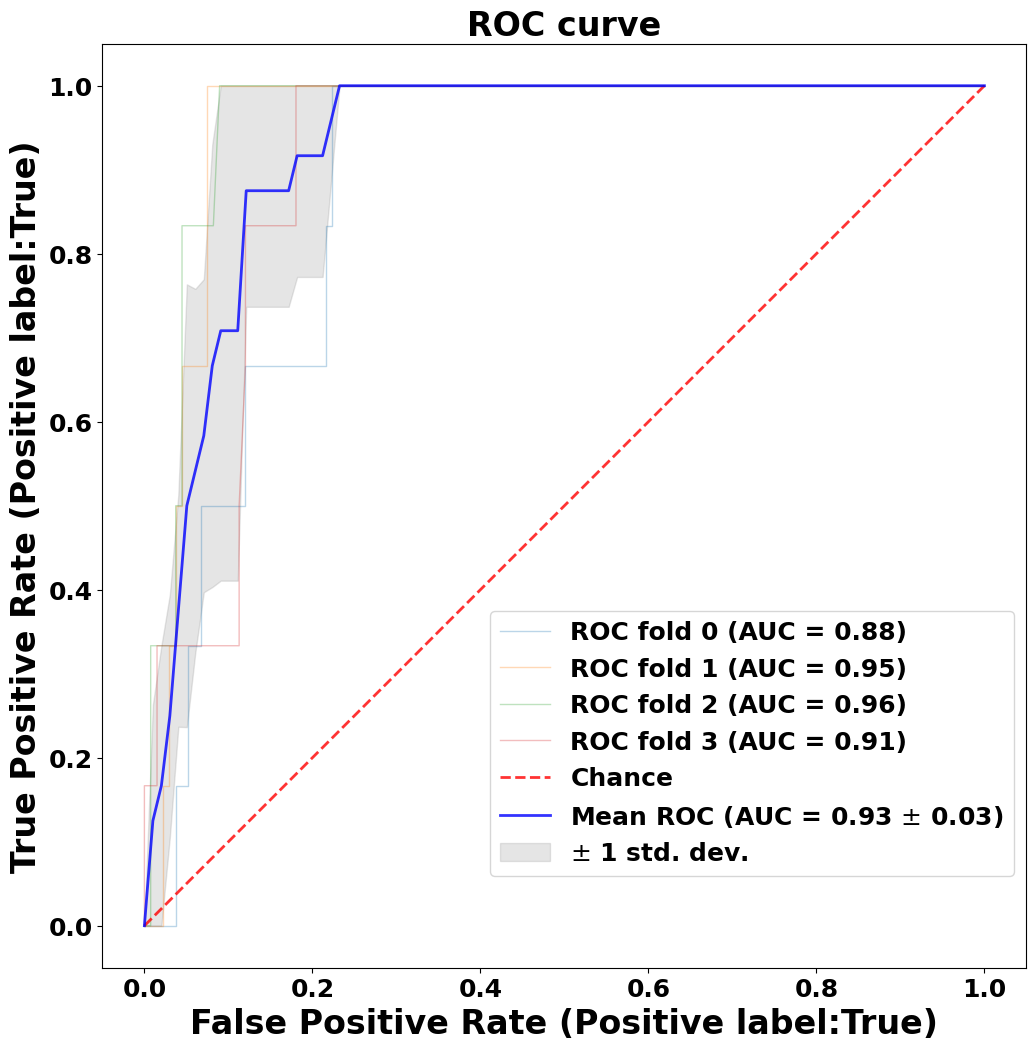

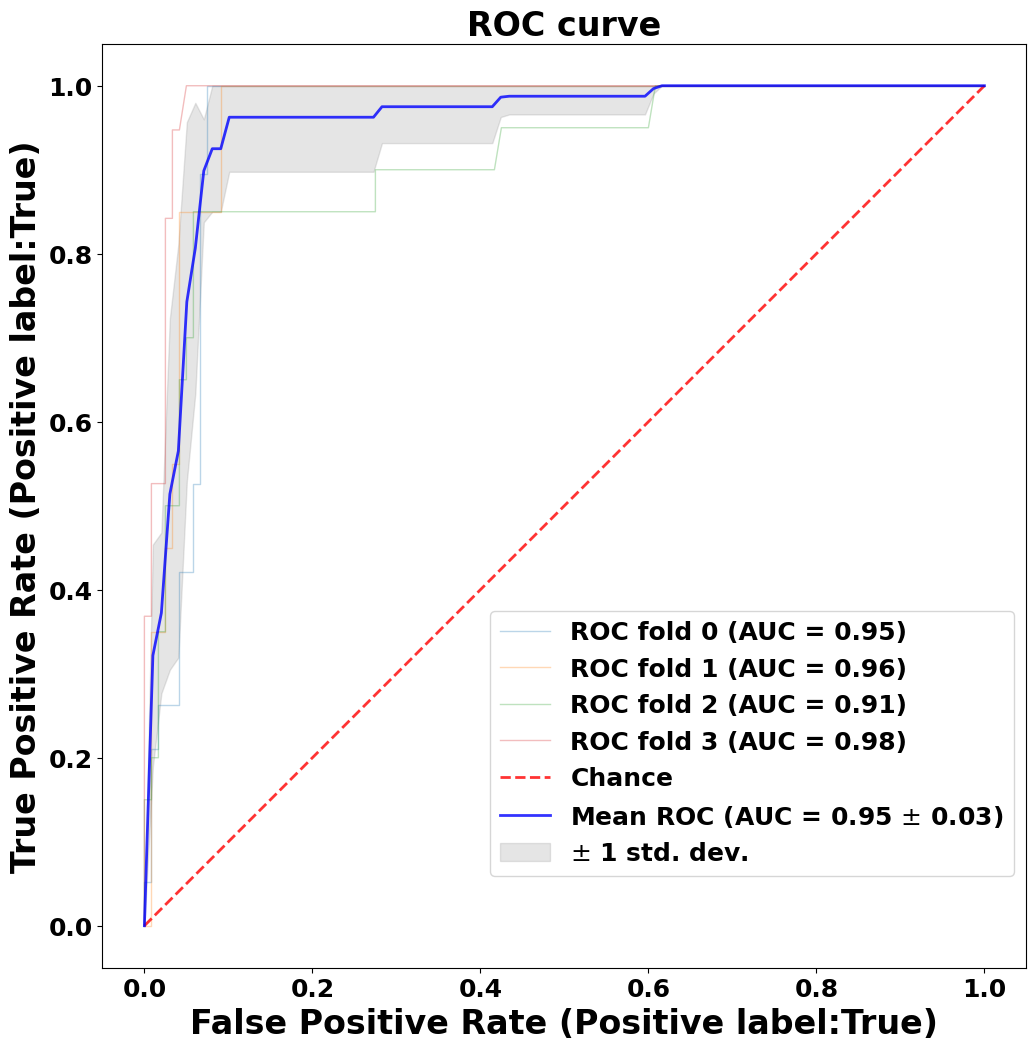

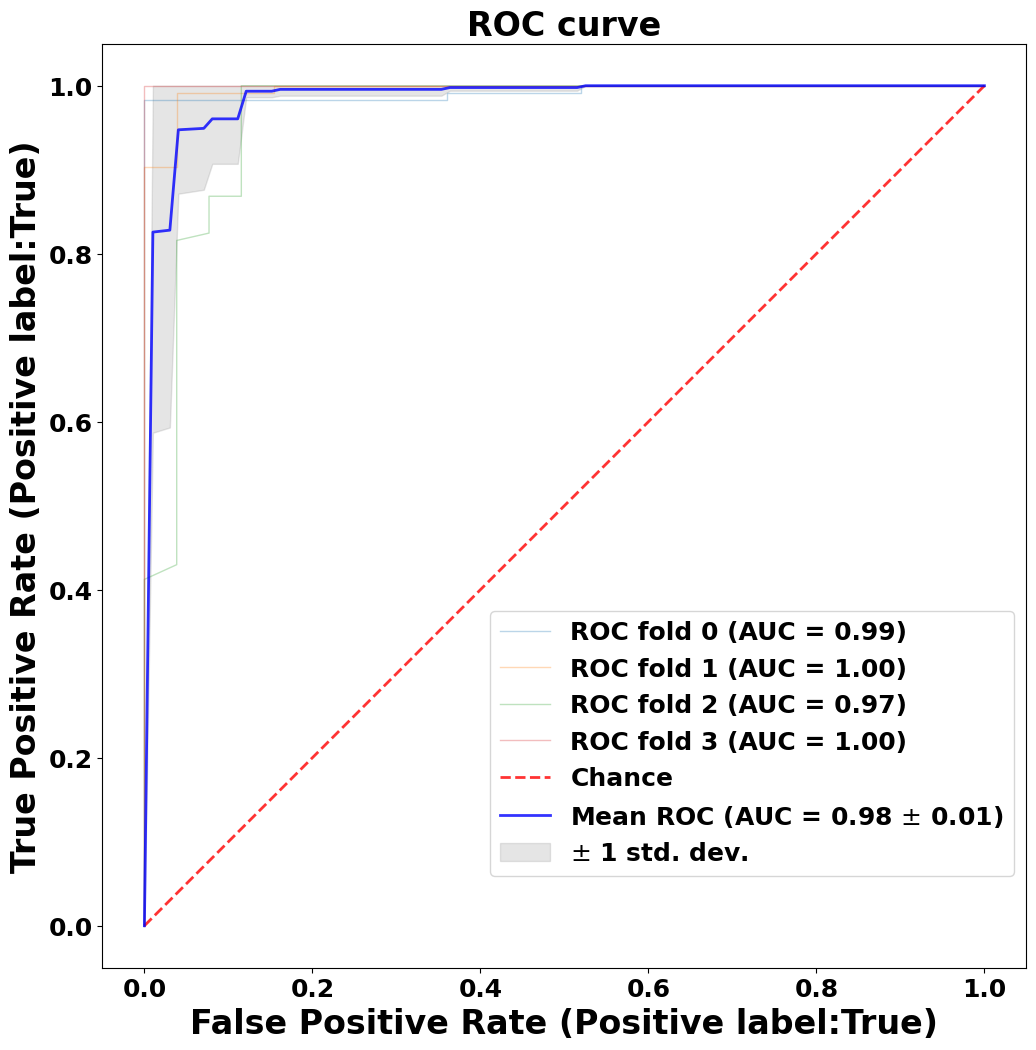

In [25]:
# 予測精度を視覚的に評価するために、ROCカーブをプロットする
data_box_3 = [] #AUC保存用
cluster_l = ['G1','G2','G3~G5']
for i in range(0,3):
    cccc = cluster_l[i]
    cv = StratifiedKFold(n_splits=4)
    classifier = RandomForestClassifier(random_state = 4,class_weight='balanced',max_depth = None, min_samples_split =  2, n_estimators = 500)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    mode = []
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_facecolor('white')
    for i, (train, test) in enumerate(cv.split(X_180, y_clustlabel[cccc])):
        smote = SMOTE(sampling_strategy='auto', random_state=42)# SMOTEを適用
        X_resampled, y_resampled = smote.fit_resample(X_180.iloc[train,:], y_clustlabel[cccc][train])
        model = classifier.fit(X_resampled, y_resampled)
        
        
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_180.iloc[test,:],
            y_clustlabel[cccc][test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        Y_score = model.score(X_180.iloc[test,:],y_clustlabel[cccc][test])
        print(Y_score)
    
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC curve ",
    )
    
    data_box_3.append(np.array(aucs))
     
    plt.axis('square')
    plt.legend( bbox_to_anchor=(1, 0.4),prop={ "weight":"bold",'size':18},facecolor='white')
    plt.xlabel('False Positive Rate (Positive label:True)',weight='bold',size = 24)
    plt.ylabel('True Positive Rate (Positive label:True)',weight='bold',size = 24)
    plt.title('ROC curve',weight = 'bold',fontsize= 24)
    plt.xticks(fontsize=18,weight='bold')
    plt.yticks(fontsize=18,weight='bold')
    ax.spines['bottom'].set_color('black')  # X軸
    ax.spines['left'].set_color('black')
    


In [ ]:
fig, ax = plt.subplots(figsize=(12,10.5),facecolor='white')
ax.set_facecolor('white')
bp = plt.boxplot(data_box_3, patch_artist=True,labels=['Early-loss', 'Intermediate-loss', 'Late/No-loss'],medianprops={'color': 'black'})
color_list_=['orange','purple','grey']

for i,line in zip(bp['boxes'], color_list_):
    i.set_facecolor(line)

for median in bp['medians']:
    median.set_linewidth(3)  


plt.ylabel('AUC',size=32,weight='normal')
plt.xticks(size=28,weight='normal')
plt.yticks(size=28,weight='normal')

ax.spines['top'].set_color('white')  # X軸
ax.spines['right'].set_color('white')
plt.rcParams['font.family'] = 'Arial'
plt.savefig(path+'/Output/Fig2/Fig2D_revise.png',bbox_inches='tight')

# Fig2E

In [27]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
cluster_l = ['G1','G2','G3~G5']
shap_l_final = []
for i in range(0,3):
    print(cluster_l[i])
    rfc = RandomForestClassifier(random_state = 4,class_weight='balanced',max_depth = None, min_samples_split =  2, n_estimators = 500)
    smote = SMOTE(sampling_strategy='auto', random_state=42)# SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_180.drop(['preCr', 'Biliary_reconstruction2_ Roux-en Y', 'donor_height', 'donor_skinincision_Midline', 'precondition_ICU', 'Rp_height', 'diagnose2_Acute liver failure', 'NLR', ' GV/SLV(%)', 'Rp_weight', 'precondition_Home', 'donor_weight', 'diagnose2_Cholestasis', 'donor_technique_Right lobectomy', 'Rp BSA', 'Rp_prePT_per', 'CNI_CYA', 'expected_residual_liver', 'Suture_method_Interrupted'],axis=1), y_clustlabel[cluster_l[i]])
    clf = rfc.fit(X_resampled,y_resampled)
    
    
    
    
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_180.drop(['preCr', 'Biliary_reconstruction2_ Roux-en Y', 'donor_height', 'donor_skinincision_Midline', 'precondition_ICU', 'Rp_height', 'diagnose2_Acute liver failure', 'NLR', ' GV/SLV(%)', 'Rp_weight', 'precondition_Home', 'donor_weight', 'diagnose2_Cholestasis', 'donor_technique_Right lobectomy', 'Rp BSA', 'Rp_prePT_per', 'CNI_CYA', 'expected_residual_liver', 'Suture_method_Interrupted'],axis=1))
       
    shapvalDF = pd.DataFrame({
        "Feature":X_180.drop(['preCr', 'Biliary_reconstruction2_ Roux-en Y', 'donor_height', 'donor_skinincision_Midline', 'precondition_ICU', 'Rp_height', 'diagnose2_Acute liver failure', 'NLR', ' GV/SLV(%)', 'Rp_weight', 'precondition_Home', 'donor_weight', 'diagnose2_Cholestasis', 'donor_technique_Right lobectomy', 'Rp BSA', 'Rp_prePT_per', 'CNI_CYA', 'expected_residual_liver', 'Suture_method_Interrupted'],axis=1).columns,
        "Value":np.abs(shap_values[:,:,1]).mean(axis=0)
    })
    
    shapvalDF = shapvalDF.sort_values("Value",ascending=False)
    shap_list_c = shapvalDF["Feature"].to_list()
    shap_list_v_cl = shapvalDF['Value'].to_list()
    shap_l_final.append(shap_list_c[0:10])
    
shap_l_final




In [ ]:
#order of factor
unique_list = ['ascite_30POD_','ascite_14POD_','T_BIL_14POD_','PT_per14POD_','preHb','preNa','Rp_preT_Bil','Rp_sex_M','diagnose2_Hepatocellular disease','Rp_amount_of_bleeding','Rp_splenectomy1_1','CNI_FK',
               'introductory_MMF_Yes','preclosure portal pressure','donor_surgery_minute','donor_max_TB']
#change the columns name
category_realg = ['Ascites(30POD)','Ascites(14POD)','T-BIL(14POD)','PT%(14POD)','Hb','Na','T-BIL','Sex M','Hepatocellular disease','Blood loss','Splenectomy','CNI FK','MMF induction Yes',
                    'Final portal pressure',  'D surgery time','D max T-BIL']

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(11, 12))
ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

for i in range(0,3):
    rfc = RandomForestClassifier(random_state = 4,class_weight='balanced',max_depth = None, min_samples_split =  2, n_estimators = 500)
    smote = SMOTE(sampling_strategy='auto', random_state=42)# SMOTEを適用
    X_resampled, y_resampled = smote.fit_resample(X_180.drop(['preCr', 'Biliary_reconstruction2_ Roux-en Y', 'donor_height', 'donor_skinincision_Midline', 'precondition_ICU', 'Rp_height', 'diagnose2_Acute liver failure', 'NLR', ' GV/SLV(%)', 'Rp_weight', 'precondition_Home', 'donor_weight', 'diagnose2_Cholestasis', 'donor_technique_Right lobectomy', 'Rp BSA', 'Rp_prePT_per', 'CNI_CYA', 'expected_residual_liver', 'Suture_method_Interrupted'],axis=1), y_clustlabel[cluster_l[i]])
    clf = rfc.fit(X_resampled,y_resampled)
    #SHAPのExplainerを用意する。ランダムフォレストなのでTreeExplainerを使う。
    
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_180.drop(['preCr', 'Biliary_reconstruction2_ Roux-en Y', 'donor_height', 'donor_skinincision_Midline', 'precondition_ICU', 'Rp_height', 'diagnose2_Acute liver failure', 'NLR', ' GV/SLV(%)', 'Rp_weight', 'precondition_Home', 'donor_weight', 'diagnose2_Cholestasis', 'donor_technique_Right lobectomy', 'Rp BSA', 'Rp_prePT_per', 'CNI_CYA', 'expected_residual_liver', 'Suture_method_Interrupted'],axis=1))
    shapvalDF = pd.DataFrame({
        "Feature":X_180.drop(['preCr', 'Biliary_reconstruction2_ Roux-en Y', 'donor_height', 'donor_skinincision_Midline', 'precondition_ICU', 'Rp_height', 'diagnose2_Acute liver failure', 'NLR', ' GV/SLV(%)', 'Rp_weight', 'precondition_Home', 'donor_weight', 'diagnose2_Cholestasis', 'donor_technique_Right lobectomy', 'Rp BSA', 'Rp_prePT_per', 'CNI_CYA', 'expected_residual_liver', 'Suture_method_Interrupted'],axis=1).columns,
        "Value":np.abs(shap_values[:,:,1]).mean(axis=0)
    })
    
    shapvalDF = shapvalDF.sort_values("Value",ascending=False)
    shap_list_v_cl = []
    for k in range(len(unique_list)):
        a = shapvalDF[shapvalDF['Feature']==unique_list[k]]['Value']
        shap_list_v_cl.append(a)
    shap_list_v_cl_flat = []
    for sublist in shap_list_v_cl:
        shap_list_v_cl_flat.extend(sublist)

    if i == 0:
        ax1.barh(category_realg, shap_list_v_cl_flat, color='orange')
        ax1.set_title('Early',fontsize= 40,weight='normal')
        ax1.set_xlim([0,0.2])
        ax1.set_xticks([0,0.1])
        ax1.tick_params(axis='x', labelsize=32)
        ax1.tick_params(axis='y', labelsize=30)
        ax1.spines['top'].set_color('white')  # X軸
        ax1.spines['right'].set_color('white')
    elif i == 1:
        #グラフ2のプロット
        ax2.barh(category_realg, shap_list_v_cl_flat, color='purple')
        ax2.set_title('Intermediate',fontsize= 40,weight='normal')
        ax2.set_yticks([])
        ax2.set_xlim([0,0.2])
        ax2.set_xticks([0,0.1])
        ax2.tick_params(axis='x', labelsize=32)
        ax2.yaxis.tick_left()
        ax2.spines['top'].set_color('white')  # X軸
        ax2.spines['right'].set_color('white')
    else:
        ax3.barh(category_realg, shap_list_v_cl_flat, color='grey')
        ax3.set_title('Long/No',fontsize= 40,weight='normal')
        ax3.set_yticks([])
        ax3.set_xlim([0,0.2])
        ax3.set_xticks([0,0.1])
        ax3.tick_params(axis='x', labelsize=32)
        ax3.yaxis.tick_left()
        ax3.spines['top'].set_color('white')  # X軸
        ax3.spines['right'].set_color('white')

plt.savefig(path+'/Output/Fig2/Fig2E_revise.png',bbox_inches='tight')
            